In [1]:
import os
import numpy as np
from tqdm import tqdm
import copy
import boto3

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

from models import MobileNetV3
from data_preparation import CreateDataset, load_images_and_labels, encode_labels, create_data_augmentation
from trainer import prune_model, remove_pruning, count_nonzero_parameters, store_pruning_masks, reapply_pruning_masks, evaluate_model, plot_losses

import multiprocessing

import pickle

num_workers = multiprocessing.cpu_count()

batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_num_threads(num_workers)

/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = "fer2013"

bucket_name = 'thesissagemakerbucket'
train_path = f'{data}/train'
test_path = f'{data}/test'

X_train, y_train = load_images_and_labels(bucket_name, train_path)
X_test, y_test = load_images_and_labels(bucket_name, test_path)

In [3]:
X = X_train + X_test
y = y_train + y_test

X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_test_and_val,
                                                y_test_and_val,
                                                test_size=0.5,
                                                random_state=42)

In [4]:
# label_encoder, y_train, y_test = encode_labels(y_train, y_test)
label_encoder, y_train, y_val, y_test = encode_labels(y_train, y_val, y_test)


In [5]:
transform = create_data_augmentation()

train_dataset = CreateDataset(X_train, y_train, transform=transform)
test_dataset = CreateDataset(X_test, y_test, transform=transform)
val_dataset = CreateDataset(X_val, y_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [6]:
model = MobileNetV3(num_labels=len(label_encoder.classes_)).to(device)

/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [8]:
def train_model(model,
                train_loader,
                val_loader,
                criterion,
                optimizer,
                device,
                epochs,
                prune_percent=0.2,
                total_prune_cycles=100,
                patience=3,
                cycle_patience=3):

    best_models_dict = {}
    best_model_wts = copy.deepcopy(model.state_dict())
    global_best_val_loss = np.inf
    train_losses = []
    val_losses = []

    initial_params = count_nonzero_parameters(model)
    print(f"Initial non-zero parameters: {initial_params}")

    no_improvement_cycles = 0

    for cycle in range(total_prune_cycles):
        print(f"Pruning cycle {cycle + 1}/{total_prune_cycles}")

        current_params = count_nonzero_parameters(model)
        print(f"Params before cycle {cycle + 1}: {current_params}")

        cycle_best_val_loss = np.inf
        cycle_best_model_wts = copy.deepcopy(model.state_dict())
        no_improvement_epochs = 0

        for epoch in range(epochs):
            model.train()
            total_train_loss = 0

            for images, labels in tqdm(train_loader, desc=f"Cycle {cycle + 1}, Epoch {epoch + 1}"):
                images = images.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()

                for name, param in model.named_parameters():
                    if hasattr(param, 'mask'):
                        param.grad *= param.mask

                optimizer.step()

                total_train_loss += loss.item()

                del images, labels, outputs, loss
                torch.cuda.empty_cache()

            avg_train_loss = total_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            model.eval()
            total_val_loss = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    total_val_loss += loss.item()

                    del images, labels, outputs, loss
                    torch.cuda.empty_cache()

            avg_val_loss = total_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

            if avg_val_loss < cycle_best_val_loss:
                cycle_best_val_loss = avg_val_loss
                pruning_masks = store_pruning_masks(model)
                remove_pruning(model)
                cycle_best_model_wts = copy.deepcopy(model.state_dict())
                reapply_pruning_masks(model, pruning_masks)
                no_improvement_epochs = 0
            else:
                no_improvement_epochs += 1

            if avg_val_loss < global_best_val_loss:
                global_best_val_loss = avg_val_loss
                pruning_masks = store_pruning_masks(model)
                remove_pruning(model)
                cycle_best_model_wts = copy.deepcopy(model.state_dict())
                reapply_pruning_masks(model, pruning_masks)

            if no_improvement_epochs >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1} of cycle {cycle + 1}")
                break

        print(f"Cycle best loss: {cycle_best_val_loss}")
        print(f"Global best loss: {global_best_val_loss}")
        if cycle_best_val_loss == global_best_val_loss:
            global_best_val_loss = cycle_best_val_loss
            no_improvement_cycles = 0
            print(f"New global best validation loss: {global_best_val_loss:.4f} at cycle {cycle + 1}")
        else:
            no_improvement_cycles += 1
            print(f"No improvement in cycle {cycle + 1}. Cycle patience: {no_improvement_cycles}/{cycle_patience}")

        if no_improvement_cycles >= cycle_patience:
            print(f"Early stopping after {cycle + 1} cycles with no improvement.")
            break

        pruning_masks = store_pruning_masks(model)
        remove_pruning(model)
        
        model.load_state_dict(cycle_best_model_wts)
            
        best_models_dict[cycle + 1] = {
            'cycle': cycle + 1,
            'model': copy.deepcopy(model.state_dict()),
            'params': count_nonzero_parameters(model),
            'min_val_loss': cycle_best_val_loss
        }
        
        reapply_pruning_masks(model, pruning_masks)
        
        try:
            prune_model(model, prune_percent)
        except:
            print("Achieved max amount for pruning")
            current_params = count_nonzero_parameters(model)
            print(f"Parameters after cycle {cycle + 1}: {current_params}")
            break

        current_params = count_nonzero_parameters(model)
        print(f"Parameters after cycle {cycle + 1}: {current_params}")

    remove_pruning(model)
    model.load_state_dict(best_model_wts)

    final_params = count_nonzero_parameters(model)
    print(f"Best model count of paramenters: {final_params}")

    return model, best_models_dict, train_losses, val_losses

model, best_models_dict, train_loss, val_loss = train_model(
                                   model=model,
                                   train_loader=train_loader,
                                   val_loader=val_loader,
                                   criterion=criterion,
                                   optimizer=optimizer,
                                   device=device,
                                   epochs=500,
                                   patience=10,
                                   prune_percent=0.1,
                                   total_prune_cycles=20,
                                   cycle_patience=10)

Initial non-zero parameters: 1515056
Pruning cycle 1/20
Params before cycle 1: 1515056


Cycle 1, Epoch 1: 100%|██████████| 561/561 [00:34<00:00, 16.37it/s]


Epoch 1, Train Loss: 1.5067, Validation Loss: 1.4343


Cycle 1, Epoch 2: 100%|██████████| 561/561 [00:33<00:00, 16.62it/s]


Epoch 2, Train Loss: 1.2632, Validation Loss: 1.2561


Cycle 1, Epoch 3: 100%|██████████| 561/561 [00:33<00:00, 16.52it/s]


Epoch 3, Train Loss: 1.1635, Validation Loss: 1.1599


Cycle 1, Epoch 4: 100%|██████████| 561/561 [00:33<00:00, 16.87it/s]


Epoch 4, Train Loss: 1.0974, Validation Loss: 1.1532


Cycle 1, Epoch 5: 100%|██████████| 561/561 [00:33<00:00, 16.51it/s]


Epoch 5, Train Loss: 1.0482, Validation Loss: 1.1375


Cycle 1, Epoch 6: 100%|██████████| 561/561 [00:34<00:00, 16.45it/s]


Epoch 6, Train Loss: 1.0058, Validation Loss: 1.1068


Cycle 1, Epoch 7: 100%|██████████| 561/561 [00:33<00:00, 16.54it/s]


Epoch 7, Train Loss: 0.9650, Validation Loss: 1.0738


Cycle 1, Epoch 8: 100%|██████████| 561/561 [00:33<00:00, 16.52it/s]


Epoch 8, Train Loss: 0.9266, Validation Loss: 1.0965


Cycle 1, Epoch 9: 100%|██████████| 561/561 [00:34<00:00, 16.48it/s]


Epoch 9, Train Loss: 0.8947, Validation Loss: 1.0851


Cycle 1, Epoch 10: 100%|██████████| 561/561 [00:34<00:00, 16.34it/s]


Epoch 10, Train Loss: 0.8565, Validation Loss: 1.1023


Cycle 1, Epoch 11: 100%|██████████| 561/561 [00:34<00:00, 16.47it/s]


Epoch 11, Train Loss: 0.8197, Validation Loss: 1.0913


Cycle 1, Epoch 12: 100%|██████████| 561/561 [00:34<00:00, 16.48it/s]


Epoch 12, Train Loss: 0.7886, Validation Loss: 1.1140


Cycle 1, Epoch 13: 100%|██████████| 561/561 [00:34<00:00, 16.47it/s]


Epoch 13, Train Loss: 0.7591, Validation Loss: 1.1040


Cycle 1, Epoch 14: 100%|██████████| 561/561 [00:33<00:00, 16.54it/s]


Epoch 14, Train Loss: 0.7228, Validation Loss: 1.1499


Cycle 1, Epoch 15: 100%|██████████| 561/561 [00:34<00:00, 16.47it/s]


Epoch 15, Train Loss: 0.6902, Validation Loss: 1.1796


Cycle 1, Epoch 16: 100%|██████████| 561/561 [00:33<00:00, 16.55it/s]


Epoch 16, Train Loss: 0.6552, Validation Loss: 1.1845


Cycle 1, Epoch 17: 100%|██████████| 561/561 [00:34<00:00, 16.44it/s]


Epoch 17, Train Loss: 0.6316, Validation Loss: 1.2008
Early stopping triggered at epoch 17 of cycle 1
Cycle best loss: 1.0738368621924594
Global best loss: 1.0738368621924594
New global best validation loss: 1.0738 at cycle 1
Parameters after cycle 1: 1364157
Pruning cycle 2/20
Params before cycle 2: 1364157


Cycle 2, Epoch 1: 100%|██████████| 561/561 [00:35<00:00, 16.02it/s]


Epoch 1, Train Loss: 0.9179, Validation Loss: 1.0657


Cycle 2, Epoch 2: 100%|██████████| 561/561 [00:34<00:00, 16.22it/s]


Epoch 2, Train Loss: 0.8885, Validation Loss: 1.0735


Cycle 2, Epoch 3: 100%|██████████| 561/561 [00:34<00:00, 16.41it/s]


Epoch 3, Train Loss: 0.8684, Validation Loss: 1.0804


Cycle 2, Epoch 4: 100%|██████████| 561/561 [00:34<00:00, 16.20it/s]


Epoch 4, Train Loss: 0.8421, Validation Loss: 1.0919


Cycle 2, Epoch 5: 100%|██████████| 561/561 [00:34<00:00, 16.27it/s]


Epoch 5, Train Loss: 0.8202, Validation Loss: 1.0840


Cycle 2, Epoch 6: 100%|██████████| 561/561 [00:34<00:00, 16.03it/s]


Epoch 6, Train Loss: 0.7802, Validation Loss: 1.1034


Cycle 2, Epoch 7: 100%|██████████| 561/561 [00:34<00:00, 16.19it/s]


Epoch 7, Train Loss: 0.7525, Validation Loss: 1.1149


Cycle 2, Epoch 8: 100%|██████████| 561/561 [00:34<00:00, 16.24it/s]


Epoch 8, Train Loss: 0.7291, Validation Loss: 1.1255


Cycle 2, Epoch 9: 100%|██████████| 561/561 [00:34<00:00, 16.26it/s]


Epoch 9, Train Loss: 0.6936, Validation Loss: 1.1266


Cycle 2, Epoch 10: 100%|██████████| 561/561 [00:34<00:00, 16.34it/s]


Epoch 10, Train Loss: 0.6646, Validation Loss: 1.1838


Cycle 2, Epoch 11: 100%|██████████| 561/561 [00:34<00:00, 16.27it/s]


Epoch 11, Train Loss: 0.6294, Validation Loss: 1.2042
Early stopping triggered at epoch 11 of cycle 2
Cycle best loss: 1.0656621971588542
Global best loss: 1.0656621971588542
New global best validation loss: 1.0657 at cycle 2
Parameters after cycle 2: 1228348
Pruning cycle 3/20
Params before cycle 3: 1228348


Cycle 3, Epoch 1: 100%|██████████| 561/561 [00:35<00:00, 15.94it/s]


Epoch 1, Train Loss: 0.8952, Validation Loss: 1.0652


Cycle 3, Epoch 2: 100%|██████████| 561/561 [00:34<00:00, 16.06it/s]


Epoch 2, Train Loss: 0.8755, Validation Loss: 1.0880


Cycle 3, Epoch 3: 100%|██████████| 561/561 [00:34<00:00, 16.08it/s]


Epoch 3, Train Loss: 0.8478, Validation Loss: 1.0861


Cycle 3, Epoch 4: 100%|██████████| 561/561 [00:34<00:00, 16.11it/s]


Epoch 4, Train Loss: 0.8244, Validation Loss: 1.0806


Cycle 3, Epoch 5: 100%|██████████| 561/561 [00:35<00:00, 15.94it/s]


Epoch 5, Train Loss: 0.7980, Validation Loss: 1.0755


Cycle 3, Epoch 6: 100%|██████████| 561/561 [00:35<00:00, 15.92it/s]


Epoch 6, Train Loss: 0.7701, Validation Loss: 1.0966


Cycle 3, Epoch 7: 100%|██████████| 561/561 [00:34<00:00, 16.10it/s]


Epoch 7, Train Loss: 0.7383, Validation Loss: 1.1186


Cycle 3, Epoch 8: 100%|██████████| 561/561 [00:34<00:00, 16.12it/s]


Epoch 8, Train Loss: 0.7094, Validation Loss: 1.1226


Cycle 3, Epoch 9: 100%|██████████| 561/561 [00:34<00:00, 16.10it/s]


Epoch 9, Train Loss: 0.6818, Validation Loss: 1.1356


Cycle 3, Epoch 10: 100%|██████████| 561/561 [00:35<00:00, 15.71it/s]


Epoch 10, Train Loss: 0.6575, Validation Loss: 1.1632


Cycle 3, Epoch 11: 100%|██████████| 561/561 [00:34<00:00, 16.07it/s]


Epoch 11, Train Loss: 0.6251, Validation Loss: 1.1916
Early stopping triggered at epoch 11 of cycle 3
Cycle best loss: 1.0651798422226277
Global best loss: 1.0651798422226277
New global best validation loss: 1.0652 at cycle 3
Parameters after cycle 3: 1106117
Pruning cycle 4/20
Params before cycle 4: 1106117


Cycle 4, Epoch 1: 100%|██████████| 561/561 [00:35<00:00, 15.89it/s]


Epoch 1, Train Loss: 0.8806, Validation Loss: 1.0773


Cycle 4, Epoch 2: 100%|██████████| 561/561 [00:34<00:00, 16.44it/s]


Epoch 2, Train Loss: 0.8512, Validation Loss: 1.0660


Cycle 4, Epoch 3: 100%|██████████| 561/561 [00:34<00:00, 16.11it/s]


Epoch 3, Train Loss: 0.8288, Validation Loss: 1.0803


Cycle 4, Epoch 4: 100%|██████████| 561/561 [00:34<00:00, 16.29it/s]


Epoch 4, Train Loss: 0.8094, Validation Loss: 1.1097


Cycle 4, Epoch 5: 100%|██████████| 561/561 [00:34<00:00, 16.17it/s]


Epoch 5, Train Loss: 0.7880, Validation Loss: 1.0861


Cycle 4, Epoch 6: 100%|██████████| 561/561 [00:34<00:00, 16.10it/s]


Epoch 6, Train Loss: 0.7547, Validation Loss: 1.1210


Cycle 4, Epoch 7: 100%|██████████| 561/561 [00:34<00:00, 16.15it/s]


Epoch 7, Train Loss: 0.7319, Validation Loss: 1.1187


Cycle 4, Epoch 8: 100%|██████████| 561/561 [00:34<00:00, 16.06it/s]


Epoch 8, Train Loss: 0.7071, Validation Loss: 1.1098


Cycle 4, Epoch 9: 100%|██████████| 561/561 [00:34<00:00, 16.26it/s]


Epoch 9, Train Loss: 0.6826, Validation Loss: 1.1417


Cycle 4, Epoch 10: 100%|██████████| 561/561 [00:34<00:00, 16.25it/s]


Epoch 10, Train Loss: 0.6519, Validation Loss: 1.1567


Cycle 4, Epoch 11: 100%|██████████| 561/561 [00:34<00:00, 16.13it/s]


Epoch 11, Train Loss: 0.6261, Validation Loss: 1.1563


Cycle 4, Epoch 12: 100%|██████████| 561/561 [00:34<00:00, 16.21it/s]


Epoch 12, Train Loss: 0.6013, Validation Loss: 1.2041
Early stopping triggered at epoch 12 of cycle 4
Cycle best loss: 1.0660063041062542
Global best loss: 1.0651798422226277
No improvement in cycle 4. Cycle patience: 1/10
Parameters after cycle 4: 996107
Pruning cycle 5/20
Params before cycle 5: 996107


Cycle 5, Epoch 1: 100%|██████████| 561/561 [00:34<00:00, 16.29it/s]


Epoch 1, Train Loss: 0.8603, Validation Loss: 1.0993


Cycle 5, Epoch 2: 100%|██████████| 561/561 [00:34<00:00, 16.34it/s]


Epoch 2, Train Loss: 0.8233, Validation Loss: 1.0881


Cycle 5, Epoch 3: 100%|██████████| 561/561 [00:33<00:00, 16.81it/s]


Epoch 3, Train Loss: 0.7966, Validation Loss: 1.0833


Cycle 5, Epoch 4: 100%|██████████| 561/561 [00:34<00:00, 16.39it/s]


Epoch 4, Train Loss: 0.7739, Validation Loss: 1.1005


Cycle 5, Epoch 5: 100%|██████████| 561/561 [00:34<00:00, 16.35it/s]


Epoch 5, Train Loss: 0.7537, Validation Loss: 1.0862


Cycle 5, Epoch 6: 100%|██████████| 561/561 [00:34<00:00, 16.37it/s]


Epoch 6, Train Loss: 0.7223, Validation Loss: 1.1160


Cycle 5, Epoch 7: 100%|██████████| 561/561 [00:33<00:00, 16.56it/s]


Epoch 7, Train Loss: 0.7038, Validation Loss: 1.1317


Cycle 5, Epoch 8: 100%|██████████| 561/561 [00:33<00:00, 16.66it/s]


Epoch 8, Train Loss: 0.6763, Validation Loss: 1.1352


Cycle 5, Epoch 9: 100%|██████████| 561/561 [00:34<00:00, 16.43it/s]


Epoch 9, Train Loss: 0.6514, Validation Loss: 1.1576


Cycle 5, Epoch 10: 100%|██████████| 561/561 [00:34<00:00, 16.43it/s]


Epoch 10, Train Loss: 0.6292, Validation Loss: 1.1706


Cycle 5, Epoch 11: 100%|██████████| 561/561 [00:34<00:00, 16.32it/s]


Epoch 11, Train Loss: 0.6050, Validation Loss: 1.1892


Cycle 5, Epoch 12: 100%|██████████| 561/561 [00:34<00:00, 16.38it/s]


Epoch 12, Train Loss: 0.5843, Validation Loss: 1.2306


Cycle 5, Epoch 13: 100%|██████████| 561/561 [00:34<00:00, 16.28it/s]


Epoch 13, Train Loss: 0.5646, Validation Loss: 1.2256
Early stopping triggered at epoch 13 of cycle 5
Cycle best loss: 1.0832622044875528
Global best loss: 1.0651798422226277
No improvement in cycle 5. Cycle patience: 2/10
Parameters after cycle 5: 897098
Pruning cycle 6/20
Params before cycle 6: 897098


Cycle 6, Epoch 1: 100%|██████████| 561/561 [00:34<00:00, 16.28it/s]


Epoch 1, Train Loss: 0.8168, Validation Loss: 1.0772


Cycle 6, Epoch 2: 100%|██████████| 561/561 [00:34<00:00, 16.29it/s]


Epoch 2, Train Loss: 0.7777, Validation Loss: 1.0858


Cycle 6, Epoch 3: 100%|██████████| 561/561 [00:34<00:00, 16.39it/s]


Epoch 3, Train Loss: 0.7540, Validation Loss: 1.1060


Cycle 6, Epoch 4: 100%|██████████| 561/561 [00:34<00:00, 16.43it/s]


Epoch 4, Train Loss: 0.7296, Validation Loss: 1.1056


Cycle 6, Epoch 5: 100%|██████████| 561/561 [00:34<00:00, 16.28it/s]


Epoch 5, Train Loss: 0.7095, Validation Loss: 1.1135


Cycle 6, Epoch 6: 100%|██████████| 561/561 [00:34<00:00, 16.32it/s]


Epoch 6, Train Loss: 0.6822, Validation Loss: 1.1343


Cycle 6, Epoch 7: 100%|██████████| 561/561 [00:34<00:00, 16.41it/s]


Epoch 7, Train Loss: 0.6612, Validation Loss: 1.1534


Cycle 6, Epoch 8: 100%|██████████| 561/561 [00:33<00:00, 16.52it/s]


Epoch 8, Train Loss: 0.6370, Validation Loss: 1.1910


Cycle 6, Epoch 9: 100%|██████████| 561/561 [00:34<00:00, 16.36it/s]


Epoch 9, Train Loss: 0.6167, Validation Loss: 1.1753


Cycle 6, Epoch 10: 100%|██████████| 561/561 [00:34<00:00, 16.41it/s]


Epoch 10, Train Loss: 0.5944, Validation Loss: 1.2025


Cycle 6, Epoch 11: 100%|██████████| 561/561 [00:34<00:00, 16.46it/s]


Epoch 11, Train Loss: 0.5694, Validation Loss: 1.2228
Early stopping triggered at epoch 11 of cycle 6
Cycle best loss: 1.077235871998865
Global best loss: 1.0651798422226277
No improvement in cycle 6. Cycle patience: 3/10
Parameters after cycle 6: 807994
Pruning cycle 7/20
Params before cycle 7: 807994


Cycle 7, Epoch 1: 100%|██████████| 561/561 [00:34<00:00, 16.18it/s]


Epoch 1, Train Loss: 0.8589, Validation Loss: 1.0833


Cycle 7, Epoch 2: 100%|██████████| 561/561 [00:33<00:00, 16.69it/s]


Epoch 2, Train Loss: 0.8057, Validation Loss: 1.0809


Cycle 7, Epoch 3: 100%|██████████| 561/561 [00:34<00:00, 16.27it/s]


Epoch 3, Train Loss: 0.7738, Validation Loss: 1.0842


Cycle 7, Epoch 4: 100%|██████████| 561/561 [00:34<00:00, 16.31it/s]


Epoch 4, Train Loss: 0.7613, Validation Loss: 1.0952


Cycle 7, Epoch 5: 100%|██████████| 561/561 [00:34<00:00, 16.34it/s]


Epoch 5, Train Loss: 0.7237, Validation Loss: 1.1193


Cycle 7, Epoch 6: 100%|██████████| 561/561 [00:34<00:00, 16.38it/s]


Epoch 6, Train Loss: 0.7058, Validation Loss: 1.1196


Cycle 7, Epoch 7: 100%|██████████| 561/561 [00:34<00:00, 16.39it/s]


Epoch 7, Train Loss: 0.6784, Validation Loss: 1.1381


Cycle 7, Epoch 8: 100%|██████████| 561/561 [00:34<00:00, 16.28it/s]


Epoch 8, Train Loss: 0.6592, Validation Loss: 1.1585


Cycle 7, Epoch 9: 100%|██████████| 561/561 [00:34<00:00, 16.45it/s]


Epoch 9, Train Loss: 0.6417, Validation Loss: 1.1560


Cycle 7, Epoch 10: 100%|██████████| 561/561 [00:34<00:00, 16.37it/s]


Epoch 10, Train Loss: 0.6115, Validation Loss: 1.1868


Cycle 7, Epoch 11: 100%|██████████| 561/561 [00:34<00:00, 16.33it/s]


Epoch 11, Train Loss: 0.5971, Validation Loss: 1.2033


Cycle 7, Epoch 12: 100%|██████████| 561/561 [00:34<00:00, 16.38it/s]


Epoch 12, Train Loss: 0.5710, Validation Loss: 1.2264
Early stopping triggered at epoch 12 of cycle 7
Cycle best loss: 1.0809289920160354
Global best loss: 1.0651798422226277
No improvement in cycle 7. Cycle patience: 4/10
Parameters after cycle 7: 727802
Pruning cycle 8/20
Params before cycle 8: 727802


Cycle 8, Epoch 1: 100%|██████████| 561/561 [00:34<00:00, 16.20it/s]


Epoch 1, Train Loss: 0.8947, Validation Loss: 1.0904


Cycle 8, Epoch 2: 100%|██████████| 561/561 [00:34<00:00, 16.47it/s]


Epoch 2, Train Loss: 0.8233, Validation Loss: 1.0862


Cycle 8, Epoch 3: 100%|██████████| 561/561 [00:34<00:00, 16.40it/s]


Epoch 3, Train Loss: 0.7883, Validation Loss: 1.1001


Cycle 8, Epoch 4: 100%|██████████| 561/561 [00:34<00:00, 16.48it/s]


Epoch 4, Train Loss: 0.7678, Validation Loss: 1.0946


Cycle 8, Epoch 5: 100%|██████████| 561/561 [00:34<00:00, 16.39it/s]


Epoch 5, Train Loss: 0.7349, Validation Loss: 1.1012


Cycle 8, Epoch 6: 100%|██████████| 561/561 [00:34<00:00, 16.44it/s]


Epoch 6, Train Loss: 0.7202, Validation Loss: 1.1054


Cycle 8, Epoch 7: 100%|██████████| 561/561 [00:34<00:00, 16.39it/s]


Epoch 7, Train Loss: 0.6948, Validation Loss: 1.1287


Cycle 8, Epoch 8: 100%|██████████| 561/561 [00:34<00:00, 16.24it/s]


Epoch 8, Train Loss: 0.6750, Validation Loss: 1.1519


Cycle 8, Epoch 9: 100%|██████████| 561/561 [00:34<00:00, 16.37it/s]


Epoch 9, Train Loss: 0.6511, Validation Loss: 1.1631


Cycle 8, Epoch 10: 100%|██████████| 561/561 [00:34<00:00, 16.35it/s]


Epoch 10, Train Loss: 0.6377, Validation Loss: 1.1712


Cycle 8, Epoch 11: 100%|██████████| 561/561 [00:34<00:00, 16.39it/s]


Epoch 11, Train Loss: 0.6097, Validation Loss: 1.1705


Cycle 8, Epoch 12: 100%|██████████| 561/561 [00:34<00:00, 16.36it/s]


Epoch 12, Train Loss: 0.5937, Validation Loss: 1.1882
Early stopping triggered at epoch 12 of cycle 8
Cycle best loss: 1.0861730554349907
Global best loss: 1.0651798422226277
No improvement in cycle 8. Cycle patience: 5/10
Parameters after cycle 8: 655622
Pruning cycle 9/20
Params before cycle 9: 655622


Cycle 9, Epoch 1: 100%|██████████| 561/561 [00:34<00:00, 16.37it/s]


Epoch 1, Train Loss: 0.9073, Validation Loss: 1.0792


Cycle 9, Epoch 2: 100%|██████████| 561/561 [00:33<00:00, 16.61it/s]


Epoch 2, Train Loss: 0.8401, Validation Loss: 1.0923


Cycle 9, Epoch 3: 100%|██████████| 561/561 [00:33<00:00, 16.61it/s]


Epoch 3, Train Loss: 0.8076, Validation Loss: 1.0938


Cycle 9, Epoch 4: 100%|██████████| 561/561 [00:33<00:00, 16.62it/s]


Epoch 4, Train Loss: 0.7816, Validation Loss: 1.0944


Cycle 9, Epoch 5: 100%|██████████| 561/561 [00:33<00:00, 16.64it/s]


Epoch 5, Train Loss: 0.7614, Validation Loss: 1.1199


Cycle 9, Epoch 6: 100%|██████████| 561/561 [00:33<00:00, 16.56it/s]


Epoch 6, Train Loss: 0.7340, Validation Loss: 1.1080


Cycle 9, Epoch 7: 100%|██████████| 561/561 [00:33<00:00, 16.58it/s]


Epoch 7, Train Loss: 0.7181, Validation Loss: 1.1332


Cycle 9, Epoch 8: 100%|██████████| 561/561 [00:33<00:00, 16.62it/s]


Epoch 8, Train Loss: 0.6951, Validation Loss: 1.1346


Cycle 9, Epoch 9: 100%|██████████| 561/561 [00:33<00:00, 16.65it/s]


Epoch 9, Train Loss: 0.6737, Validation Loss: 1.1388


Cycle 9, Epoch 10: 100%|██████████| 561/561 [00:34<00:00, 16.49it/s]


Epoch 10, Train Loss: 0.6529, Validation Loss: 1.1729


Cycle 9, Epoch 11: 100%|██████████| 561/561 [00:33<00:00, 16.57it/s]


Epoch 11, Train Loss: 0.6397, Validation Loss: 1.1948
Early stopping triggered at epoch 11 of cycle 9
Cycle best loss: 1.0791909240743018
Global best loss: 1.0651798422226277
No improvement in cycle 9. Cycle patience: 6/10
Parameters after cycle 9: 590669
Pruning cycle 10/20
Params before cycle 10: 590669


Cycle 10, Epoch 1: 100%|██████████| 561/561 [00:34<00:00, 16.47it/s]


Epoch 1, Train Loss: 0.9785, Validation Loss: 1.1101


Cycle 10, Epoch 2: 100%|██████████| 561/561 [00:33<00:00, 16.69it/s]


Epoch 2, Train Loss: 0.9096, Validation Loss: 1.0932


Cycle 10, Epoch 3: 100%|██████████| 561/561 [00:33<00:00, 16.54it/s]


Epoch 3, Train Loss: 0.8718, Validation Loss: 1.0923


Cycle 10, Epoch 4: 100%|██████████| 561/561 [00:33<00:00, 16.57it/s]


Epoch 4, Train Loss: 0.8437, Validation Loss: 1.1035


Cycle 10, Epoch 5: 100%|██████████| 561/561 [00:33<00:00, 16.61it/s]


Epoch 5, Train Loss: 0.8146, Validation Loss: 1.0970


Cycle 10, Epoch 6: 100%|██████████| 561/561 [00:34<00:00, 16.49it/s]


Epoch 6, Train Loss: 0.7924, Validation Loss: 1.0942


Cycle 10, Epoch 7: 100%|██████████| 561/561 [00:33<00:00, 16.66it/s]


Epoch 7, Train Loss: 0.7712, Validation Loss: 1.0869


Cycle 10, Epoch 8: 100%|██████████| 561/561 [00:34<00:00, 16.43it/s]


Epoch 8, Train Loss: 0.7568, Validation Loss: 1.1082


Cycle 10, Epoch 9: 100%|██████████| 561/561 [00:33<00:00, 16.55it/s]


Epoch 9, Train Loss: 0.7322, Validation Loss: 1.1222


Cycle 10, Epoch 10: 100%|██████████| 561/561 [00:34<00:00, 16.46it/s]


Epoch 10, Train Loss: 0.7154, Validation Loss: 1.1240


Cycle 10, Epoch 11: 100%|██████████| 561/561 [00:33<00:00, 16.51it/s]


Epoch 11, Train Loss: 0.6978, Validation Loss: 1.1216


Cycle 10, Epoch 12: 100%|██████████| 561/561 [00:33<00:00, 16.72it/s]


Epoch 12, Train Loss: 0.6768, Validation Loss: 1.1256


Cycle 10, Epoch 13: 100%|██████████| 561/561 [00:33<00:00, 16.60it/s]


Epoch 13, Train Loss: 0.6642, Validation Loss: 1.1527


Cycle 10, Epoch 14: 100%|██████████| 561/561 [00:33<00:00, 16.58it/s]


Epoch 14, Train Loss: 0.6502, Validation Loss: 1.1615


Cycle 10, Epoch 15: 100%|██████████| 561/561 [00:33<00:00, 16.63it/s]


Epoch 15, Train Loss: 0.6331, Validation Loss: 1.1904


Cycle 10, Epoch 16: 100%|██████████| 561/561 [00:33<00:00, 16.56it/s]


Epoch 16, Train Loss: 0.6153, Validation Loss: 1.1940


Cycle 10, Epoch 17: 100%|██████████| 561/561 [00:33<00:00, 16.55it/s]


Epoch 17, Train Loss: 0.5996, Validation Loss: 1.1947
Early stopping triggered at epoch 17 of cycle 10
Cycle best loss: 1.0868604261680006
Global best loss: 1.0651798422226277
No improvement in cycle 10. Cycle patience: 7/10
Parameters after cycle 10: 532205
Pruning cycle 11/20
Params before cycle 11: 532205


Cycle 11, Epoch 1: 100%|██████████| 561/561 [00:33<00:00, 16.52it/s]


Epoch 1, Train Loss: 0.9482, Validation Loss: 1.1289


Cycle 11, Epoch 2: 100%|██████████| 561/561 [00:33<00:00, 16.83it/s]


Epoch 2, Train Loss: 0.8240, Validation Loss: 1.1048


Cycle 11, Epoch 3: 100%|██████████| 561/561 [00:34<00:00, 16.49it/s]


Epoch 3, Train Loss: 0.7931, Validation Loss: 1.1090


Cycle 11, Epoch 4: 100%|██████████| 561/561 [00:33<00:00, 16.53it/s]


Epoch 4, Train Loss: 0.7613, Validation Loss: 1.1074


Cycle 11, Epoch 5: 100%|██████████| 561/561 [00:33<00:00, 16.57it/s]


Epoch 5, Train Loss: 0.7367, Validation Loss: 1.1183


Cycle 11, Epoch 6: 100%|██████████| 561/561 [00:34<00:00, 16.46it/s]


Epoch 6, Train Loss: 0.7209, Validation Loss: 1.1349


Cycle 11, Epoch 7: 100%|██████████| 561/561 [00:33<00:00, 16.54it/s]


Epoch 7, Train Loss: 0.6960, Validation Loss: 1.1274


Cycle 11, Epoch 8: 100%|██████████| 561/561 [00:33<00:00, 16.58it/s]


Epoch 8, Train Loss: 0.6794, Validation Loss: 1.1513


Cycle 11, Epoch 9: 100%|██████████| 561/561 [00:33<00:00, 16.63it/s]


Epoch 9, Train Loss: 0.6614, Validation Loss: 1.1738


Cycle 11, Epoch 10: 100%|██████████| 561/561 [00:33<00:00, 16.61it/s]


Epoch 10, Train Loss: 0.6596, Validation Loss: 1.1661


Cycle 11, Epoch 11: 100%|██████████| 561/561 [00:33<00:00, 16.61it/s]


Epoch 11, Train Loss: 0.6346, Validation Loss: 1.1846


Cycle 11, Epoch 12: 100%|██████████| 561/561 [00:33<00:00, 16.69it/s]


Epoch 12, Train Loss: 0.6214, Validation Loss: 1.1841
Early stopping triggered at epoch 12 of cycle 11
Cycle best loss: 1.1047959194064565
Global best loss: 1.0651798422226277
No improvement in cycle 11. Cycle patience: 8/10
Parameters after cycle 11: 479587
Pruning cycle 12/20
Params before cycle 12: 479587


Cycle 12, Epoch 1: 100%|██████████| 561/561 [00:33<00:00, 16.57it/s]


Epoch 1, Train Loss: 0.9923, Validation Loss: 1.1221


Cycle 12, Epoch 2: 100%|██████████| 561/561 [00:33<00:00, 16.63it/s]


Epoch 2, Train Loss: 0.8968, Validation Loss: 1.1153


Cycle 12, Epoch 3: 100%|██████████| 561/561 [00:33<00:00, 16.85it/s]


Epoch 3, Train Loss: 0.8491, Validation Loss: 1.1133


Cycle 12, Epoch 4: 100%|██████████| 561/561 [00:33<00:00, 16.61it/s]


Epoch 4, Train Loss: 0.8229, Validation Loss: 1.1025


Cycle 12, Epoch 5: 100%|██████████| 561/561 [00:34<00:00, 16.38it/s]


Epoch 5, Train Loss: 0.7961, Validation Loss: 1.1025


Cycle 12, Epoch 6: 100%|██████████| 561/561 [00:33<00:00, 16.65it/s]


Epoch 6, Train Loss: 0.7809, Validation Loss: 1.1082


Cycle 12, Epoch 7: 100%|██████████| 561/561 [00:33<00:00, 16.63it/s]


Epoch 7, Train Loss: 0.7629, Validation Loss: 1.1188


Cycle 12, Epoch 8: 100%|██████████| 561/561 [00:34<00:00, 16.36it/s]


Epoch 8, Train Loss: 0.7329, Validation Loss: 1.1398


Cycle 12, Epoch 9: 100%|██████████| 561/561 [00:34<00:00, 16.43it/s]


Epoch 9, Train Loss: 0.7140, Validation Loss: 1.1544


Cycle 12, Epoch 10: 100%|██████████| 561/561 [00:34<00:00, 16.39it/s]


Epoch 10, Train Loss: 0.7021, Validation Loss: 1.1466


Cycle 12, Epoch 11: 100%|██████████| 561/561 [00:33<00:00, 16.53it/s]


Epoch 11, Train Loss: 0.6807, Validation Loss: 1.1624


Cycle 12, Epoch 12: 100%|██████████| 561/561 [00:33<00:00, 16.53it/s]


Epoch 12, Train Loss: 0.6745, Validation Loss: 1.1751


Cycle 12, Epoch 13: 100%|██████████| 561/561 [00:33<00:00, 16.50it/s]


Epoch 13, Train Loss: 0.6555, Validation Loss: 1.1795


Cycle 12, Epoch 14: 100%|██████████| 561/561 [00:33<00:00, 16.69it/s]


Epoch 14, Train Loss: 0.6443, Validation Loss: 1.1825


Cycle 12, Epoch 15: 100%|██████████| 561/561 [00:33<00:00, 16.54it/s]


Epoch 15, Train Loss: 0.6265, Validation Loss: 1.2008
Early stopping triggered at epoch 15 of cycle 12
Cycle best loss: 1.1024510630297066
Global best loss: 1.0651798422226277
No improvement in cycle 12. Cycle patience: 9/10
Parameters after cycle 12: 432237
Pruning cycle 13/20
Params before cycle 13: 432237


Cycle 13, Epoch 1: 100%|██████████| 561/561 [00:34<00:00, 16.06it/s]


Epoch 1, Train Loss: 1.0305, Validation Loss: 1.1452


Cycle 13, Epoch 2: 100%|██████████| 561/561 [00:34<00:00, 16.29it/s]


Epoch 2, Train Loss: 0.8992, Validation Loss: 1.1141


Cycle 13, Epoch 3: 100%|██████████| 561/561 [00:33<00:00, 16.64it/s]


Epoch 3, Train Loss: 0.8499, Validation Loss: 1.1207


Cycle 13, Epoch 4: 100%|██████████| 561/561 [00:33<00:00, 16.69it/s]


Epoch 4, Train Loss: 0.8246, Validation Loss: 1.1143


Cycle 13, Epoch 5: 100%|██████████| 561/561 [00:33<00:00, 16.70it/s]


Epoch 5, Train Loss: 0.7988, Validation Loss: 1.1162


Cycle 13, Epoch 6: 100%|██████████| 561/561 [00:33<00:00, 16.66it/s]


Epoch 6, Train Loss: 0.7797, Validation Loss: 1.1281


Cycle 13, Epoch 7: 100%|██████████| 561/561 [00:33<00:00, 16.65it/s]


Epoch 7, Train Loss: 0.7570, Validation Loss: 1.1388


Cycle 13, Epoch 8: 100%|██████████| 561/561 [00:33<00:00, 16.62it/s]


Epoch 8, Train Loss: 0.7377, Validation Loss: 1.1583


Cycle 13, Epoch 9: 100%|██████████| 561/561 [00:33<00:00, 16.78it/s]


Epoch 9, Train Loss: 0.7259, Validation Loss: 1.1472


Cycle 13, Epoch 10: 100%|██████████| 561/561 [00:33<00:00, 16.75it/s]


Epoch 10, Train Loss: 0.7101, Validation Loss: 1.1623


Cycle 13, Epoch 11: 100%|██████████| 561/561 [00:33<00:00, 16.81it/s]


Epoch 11, Train Loss: 0.6918, Validation Loss: 1.1678


Cycle 13, Epoch 12: 100%|██████████| 561/561 [00:33<00:00, 16.74it/s]


Epoch 12, Train Loss: 0.6802, Validation Loss: 1.1718
Early stopping triggered at epoch 12 of cycle 13
Cycle best loss: 1.1141492020192945
Global best loss: 1.0651798422226277
No improvement in cycle 13. Cycle patience: 10/10
Early stopping after 13 cycles with no improvement.
Best model count of paramenters: 1515056


In [9]:
models_dict_dir = f'{data}/models'
models_dict_path = f'lottery_models_dict_{data}.pkl'

with open(models_dict_path, 'wb') as file:
    pickle.dump(best_models_dict, file)

s3 = boto3.client('s3')
s3.upload_file(models_dict_path, bucket_name, os.path.join(models_dict_dir, models_dict_path))

os.remove(models_dict_path)

Evaluating model from cycle 1, Parameters: 1515056, Min Val Loss: 1.0738


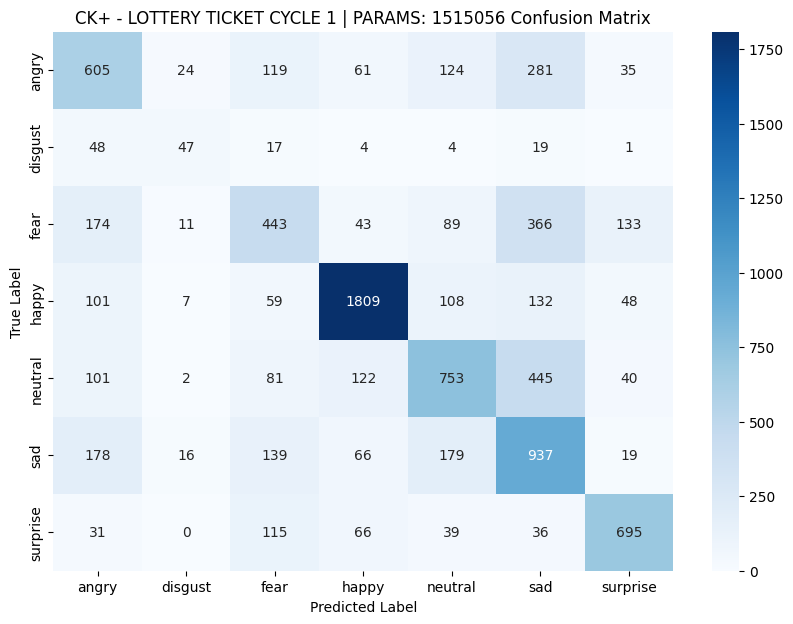

Test Accuracy: 0.5895
Precision: 0.5623
Recall: 0.5396
F1 Score: 0.5459
Classification Report:
               precision    recall  f1-score   support

       angry       0.49      0.48      0.49      1249
     disgust       0.44      0.34      0.38       140
        fear       0.46      0.35      0.40      1259
       happy       0.83      0.80      0.82      2264
     neutral       0.58      0.49      0.53      1544
         sad       0.42      0.61      0.50      1534
    surprise       0.72      0.71      0.71       982

    accuracy                           0.59      8972
   macro avg       0.56      0.54      0.55      8972
weighted avg       0.60      0.59      0.59      8972

Evaluating model from cycle 2, Parameters: 1364157, Min Val Loss: 1.0657


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


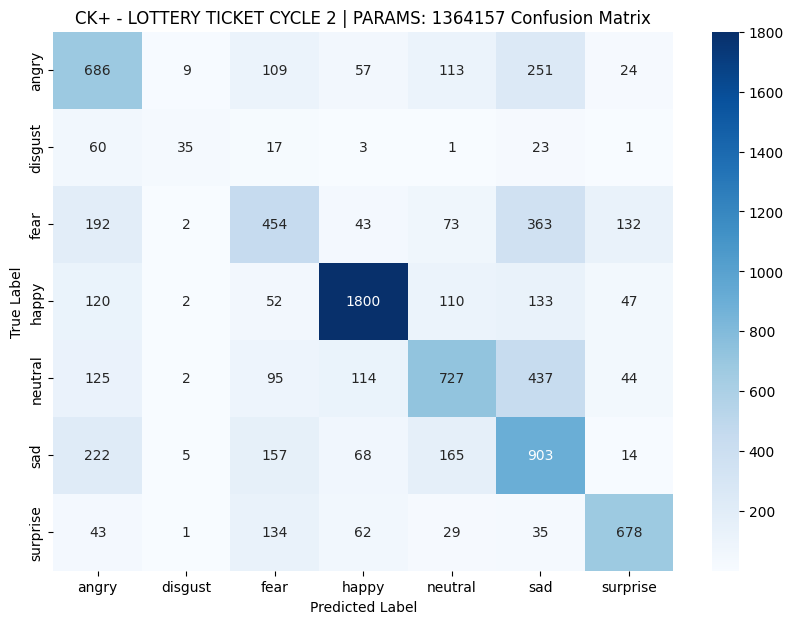

Test Accuracy: 0.5888
Precision: 0.5889
Recall: 0.5293
F1 Score: 0.5434
Classification Report:
               precision    recall  f1-score   support

       angry       0.47      0.55      0.51      1249
     disgust       0.62      0.25      0.36       140
        fear       0.45      0.36      0.40      1259
       happy       0.84      0.80      0.82      2264
     neutral       0.60      0.47      0.53      1544
         sad       0.42      0.59      0.49      1534
    surprise       0.72      0.69      0.71       982

    accuracy                           0.59      8972
   macro avg       0.59      0.53      0.54      8972
weighted avg       0.60      0.59      0.59      8972

Evaluating model from cycle 3, Parameters: 1228348, Min Val Loss: 1.0652


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


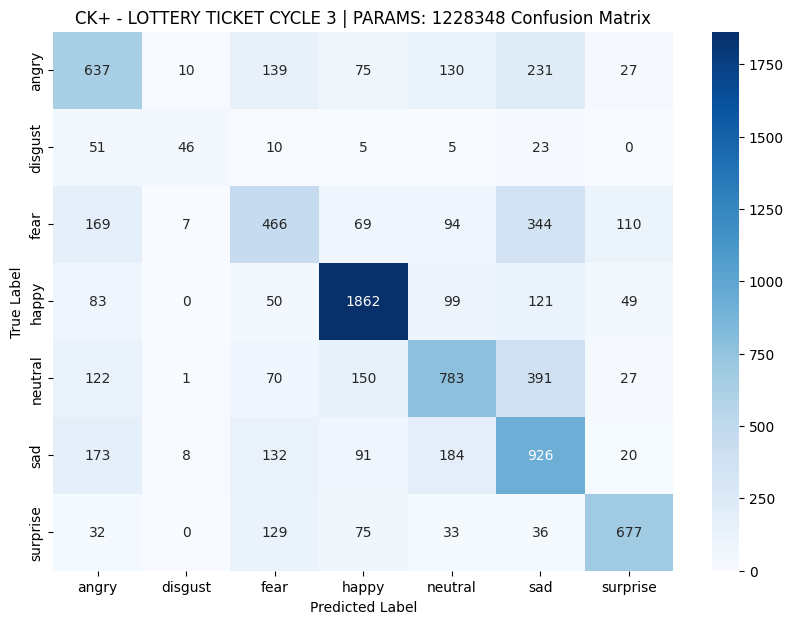

Test Accuracy: 0.6015
Precision: 0.5986
Recall: 0.5473
F1 Score: 0.5628
Classification Report:
               precision    recall  f1-score   support

       angry       0.50      0.51      0.51      1249
     disgust       0.64      0.33      0.43       140
        fear       0.47      0.37      0.41      1259
       happy       0.80      0.82      0.81      2264
     neutral       0.59      0.51      0.55      1544
         sad       0.45      0.60      0.51      1534
    surprise       0.74      0.69      0.72       982

    accuracy                           0.60      8972
   macro avg       0.60      0.55      0.56      8972
weighted avg       0.61      0.60      0.60      8972

Evaluating model from cycle 4, Parameters: 1106117, Min Val Loss: 1.0660


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


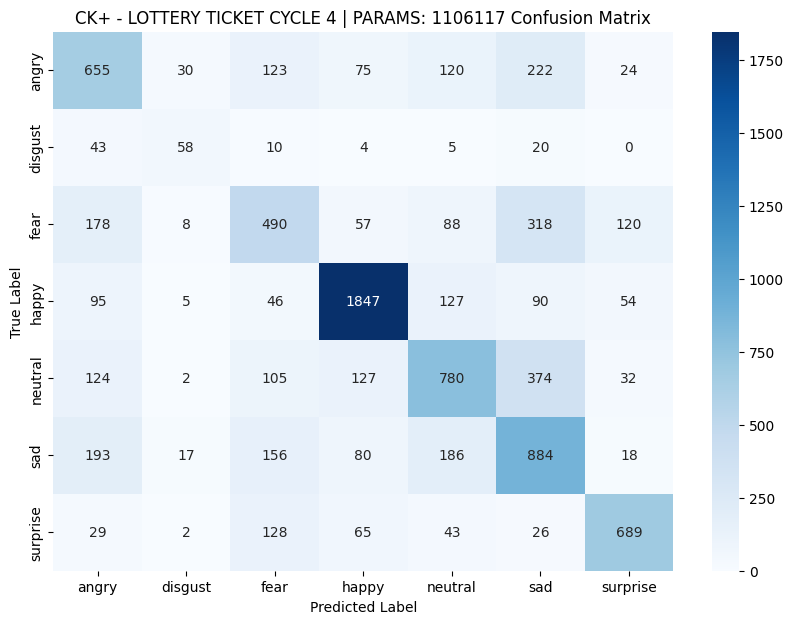

Test Accuracy: 0.6022
Precision: 0.5751
Recall: 0.5610
F1 Score: 0.5658
Classification Report:
               precision    recall  f1-score   support

       angry       0.50      0.52      0.51      1249
     disgust       0.48      0.41      0.44       140
        fear       0.46      0.39      0.42      1259
       happy       0.82      0.82      0.82      2264
     neutral       0.58      0.51      0.54      1544
         sad       0.46      0.58      0.51      1534
    surprise       0.74      0.70      0.72       982

    accuracy                           0.60      8972
   macro avg       0.58      0.56      0.57      8972
weighted avg       0.61      0.60      0.60      8972

Evaluating model from cycle 5, Parameters: 996107, Min Val Loss: 1.0833


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


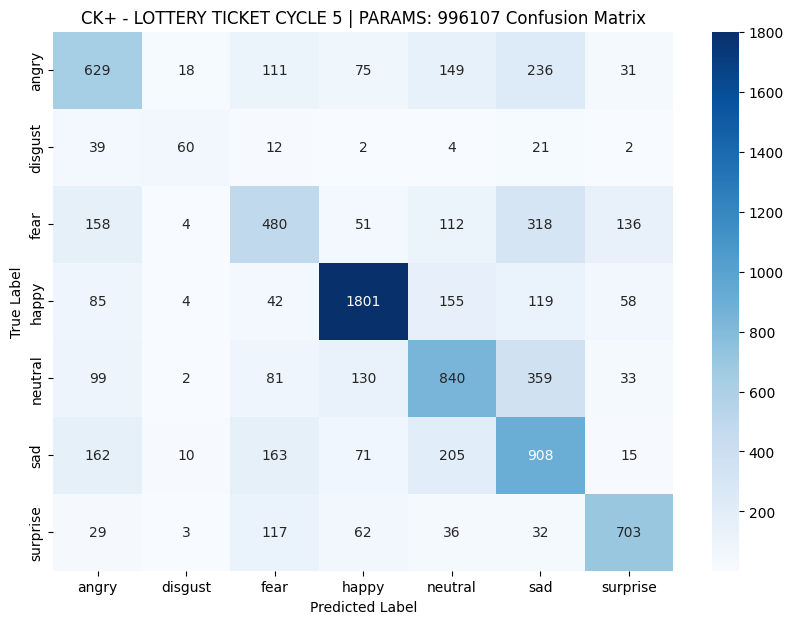

Test Accuracy: 0.6042
Precision: 0.5929
Recall: 0.5658
F1 Score: 0.5754
Classification Report:
               precision    recall  f1-score   support

       angry       0.52      0.50      0.51      1249
     disgust       0.59      0.43      0.50       140
        fear       0.48      0.38      0.42      1259
       happy       0.82      0.80      0.81      2264
     neutral       0.56      0.54      0.55      1544
         sad       0.46      0.59      0.51      1534
    surprise       0.72      0.72      0.72       982

    accuracy                           0.60      8972
   macro avg       0.59      0.57      0.58      8972
weighted avg       0.61      0.60      0.60      8972

Evaluating model from cycle 6, Parameters: 897098, Min Val Loss: 1.0772


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


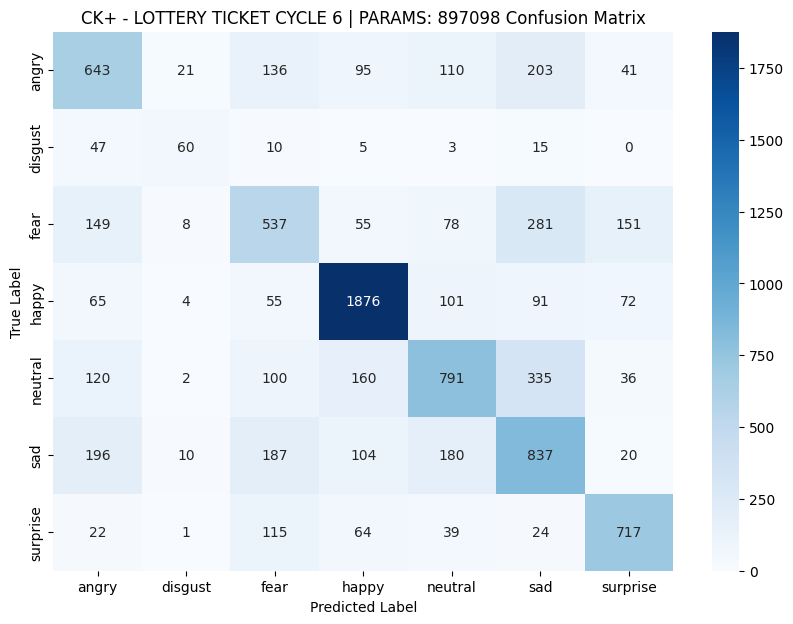

Test Accuracy: 0.6087
Precision: 0.5882
Recall: 0.5695
F1 Score: 0.5762
Classification Report:
               precision    recall  f1-score   support

       angry       0.52      0.51      0.52      1249
     disgust       0.57      0.43      0.49       140
        fear       0.47      0.43      0.45      1259
       happy       0.80      0.83      0.81      2264
     neutral       0.61      0.51      0.56      1544
         sad       0.47      0.55      0.50      1534
    surprise       0.69      0.73      0.71       982

    accuracy                           0.61      8972
   macro avg       0.59      0.57      0.58      8972
weighted avg       0.61      0.61      0.61      8972

Evaluating model from cycle 7, Parameters: 807994, Min Val Loss: 1.0809


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


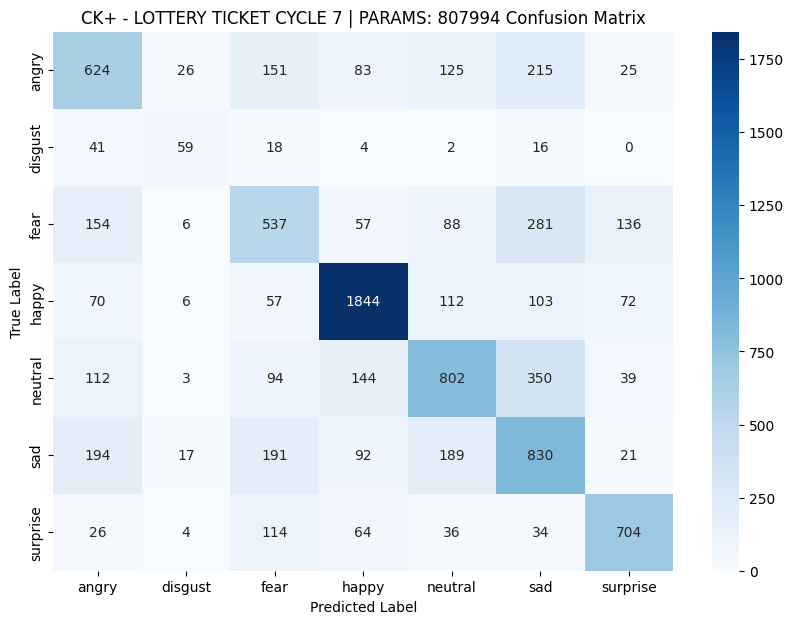

Test Accuracy: 0.6019
Precision: 0.5741
Recall: 0.5628
F1 Score: 0.5671
Classification Report:
               precision    recall  f1-score   support

       angry       0.51      0.50      0.51      1249
     disgust       0.49      0.42      0.45       140
        fear       0.46      0.43      0.44      1259
       happy       0.81      0.81      0.81      2264
     neutral       0.59      0.52      0.55      1544
         sad       0.45      0.54      0.49      1534
    surprise       0.71      0.72      0.71       982

    accuracy                           0.60      8972
   macro avg       0.57      0.56      0.57      8972
weighted avg       0.60      0.60      0.60      8972

Evaluating model from cycle 8, Parameters: 727802, Min Val Loss: 1.0862


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


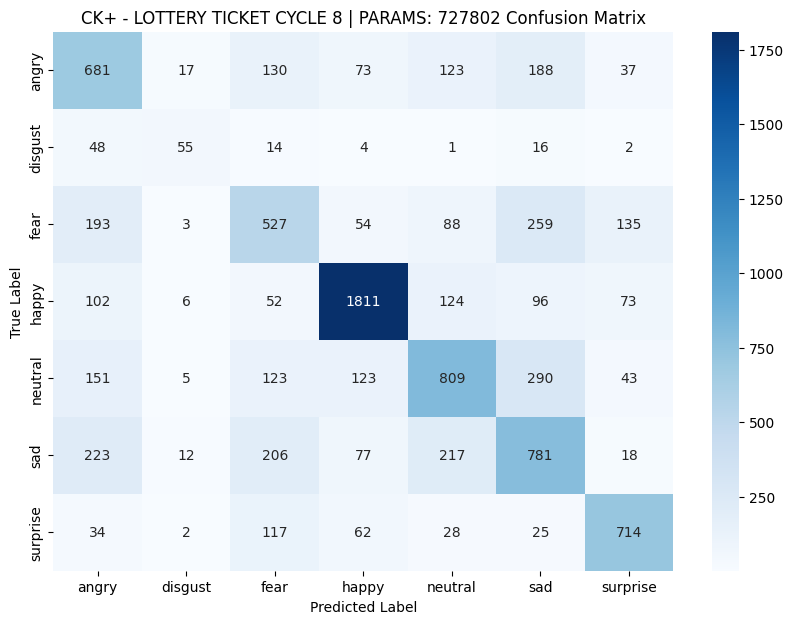

Test Accuracy: 0.5994
Precision: 0.5787
Recall: 0.5595
F1 Score: 0.5664
Classification Report:
               precision    recall  f1-score   support

       angry       0.48      0.55      0.51      1249
     disgust       0.55      0.39      0.46       140
        fear       0.45      0.42      0.43      1259
       happy       0.82      0.80      0.81      2264
     neutral       0.58      0.52      0.55      1544
         sad       0.47      0.51      0.49      1534
    surprise       0.70      0.73      0.71       982

    accuracy                           0.60      8972
   macro avg       0.58      0.56      0.57      8972
weighted avg       0.60      0.60      0.60      8972

Evaluating model from cycle 9, Parameters: 655622, Min Val Loss: 1.0792


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


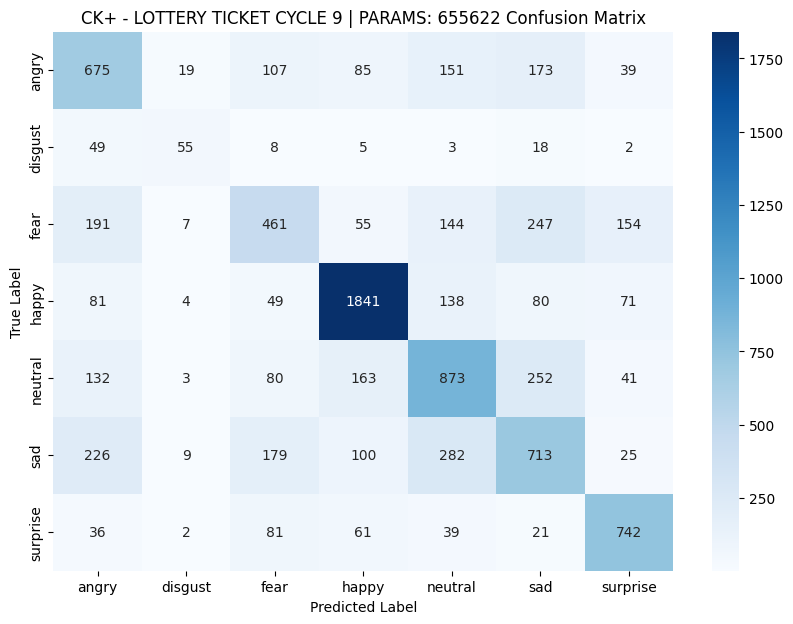

Test Accuracy: 0.5974
Precision: 0.5738
Recall: 0.5569
F1 Score: 0.5618
Classification Report:
               precision    recall  f1-score   support

       angry       0.49      0.54      0.51      1249
     disgust       0.56      0.39      0.46       140
        fear       0.48      0.37      0.41      1259
       happy       0.80      0.81      0.80      2264
     neutral       0.54      0.57      0.55      1544
         sad       0.47      0.46      0.47      1534
    surprise       0.69      0.76      0.72       982

    accuracy                           0.60      8972
   macro avg       0.57      0.56      0.56      8972
weighted avg       0.59      0.60      0.59      8972

Evaluating model from cycle 10, Parameters: 590669, Min Val Loss: 1.0869


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


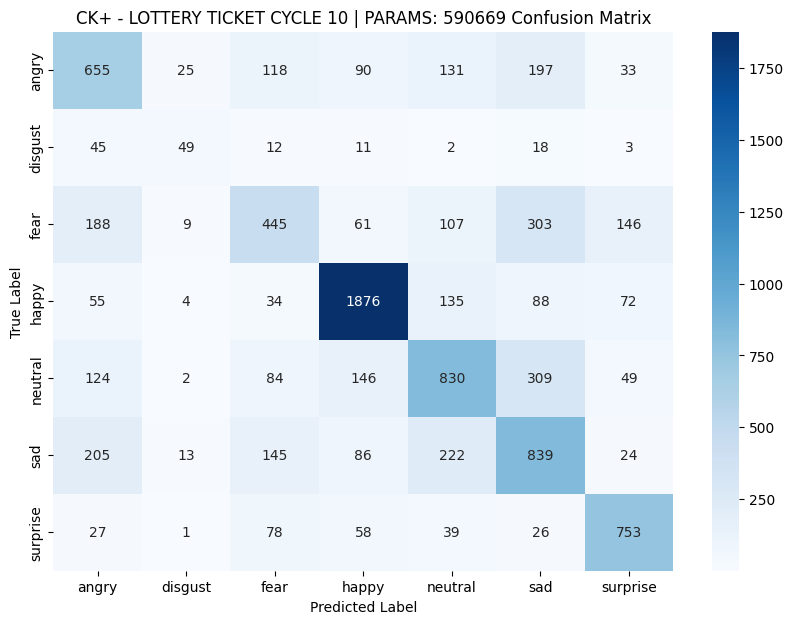

Test Accuracy: 0.6071
Precision: 0.5723
Recall: 0.5583
F1 Score: 0.5617
Classification Report:
               precision    recall  f1-score   support

       angry       0.50      0.52      0.51      1249
     disgust       0.48      0.35      0.40       140
        fear       0.49      0.35      0.41      1259
       happy       0.81      0.83      0.82      2264
     neutral       0.57      0.54      0.55      1544
         sad       0.47      0.55      0.51      1534
    surprise       0.70      0.77      0.73       982

    accuracy                           0.61      8972
   macro avg       0.57      0.56      0.56      8972
weighted avg       0.60      0.61      0.60      8972

Evaluating model from cycle 11, Parameters: 532205, Min Val Loss: 1.1048


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


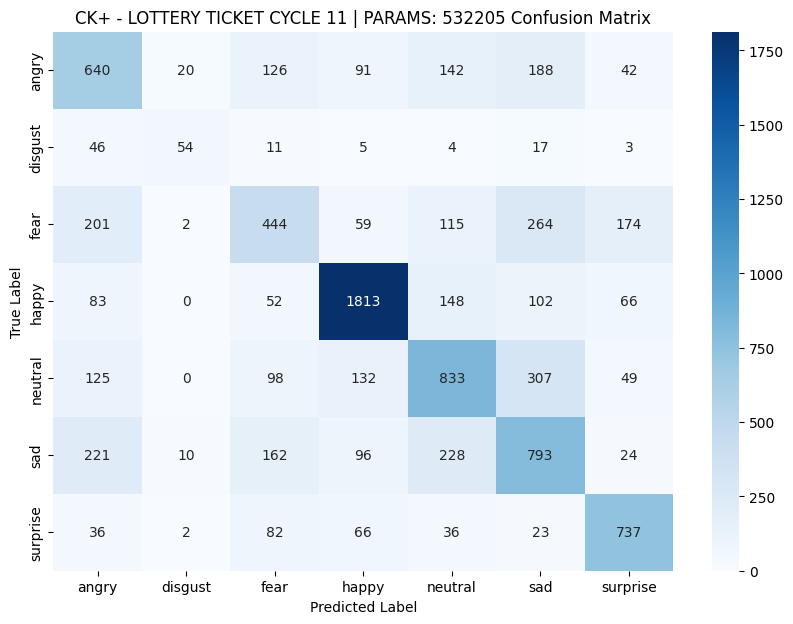

Test Accuracy: 0.5923
Precision: 0.5769
Recall: 0.5512
F1 Score: 0.5588
Classification Report:
               precision    recall  f1-score   support

       angry       0.47      0.51      0.49      1249
     disgust       0.61      0.39      0.47       140
        fear       0.46      0.35      0.40      1259
       happy       0.80      0.80      0.80      2264
     neutral       0.55      0.54      0.55      1544
         sad       0.47      0.52      0.49      1534
    surprise       0.67      0.75      0.71       982

    accuracy                           0.59      8972
   macro avg       0.58      0.55      0.56      8972
weighted avg       0.59      0.59      0.59      8972

Evaluating model from cycle 12, Parameters: 479587, Min Val Loss: 1.1025


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


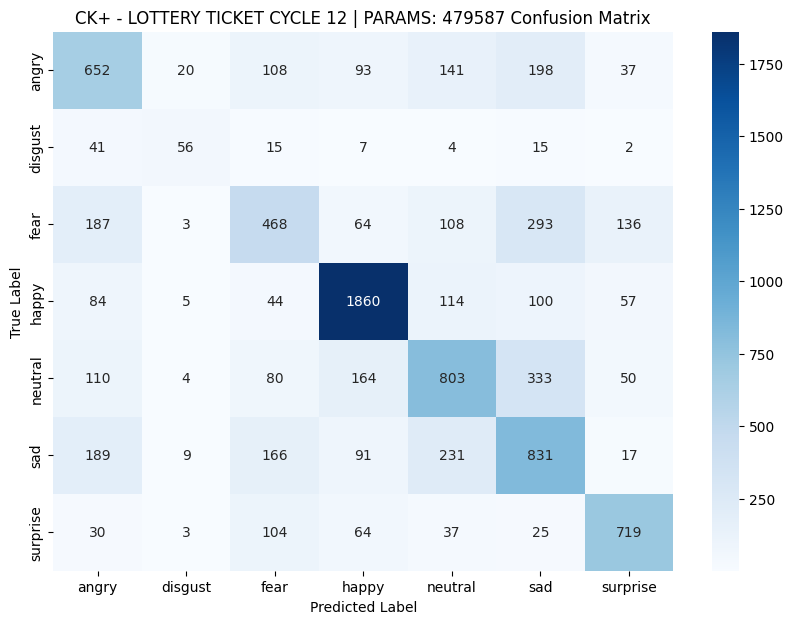

Test Accuracy: 0.6006
Precision: 0.5801
Recall: 0.5585
F1 Score: 0.5659
Classification Report:
               precision    recall  f1-score   support

       angry       0.50      0.52      0.51      1249
     disgust       0.56      0.40      0.47       140
        fear       0.48      0.37      0.42      1259
       happy       0.79      0.82      0.81      2264
     neutral       0.56      0.52      0.54      1544
         sad       0.46      0.54      0.50      1534
    surprise       0.71      0.73      0.72       982

    accuracy                           0.60      8972
   macro avg       0.58      0.56      0.57      8972
weighted avg       0.60      0.60      0.60      8972



In [10]:
def evaluate_all_models(best_models_dict, test_loader, device, data, label_encoder=None):
    for cycle, model_info in best_models_dict.items():
        model_state_dict = model_info['model']
        params = model_info['params']
        min_val_loss = model_info['min_val_loss']

        model = MobileNetV3(num_labels=len(label_encoder.classes_)).to(device)
        model.load_state_dict(model_state_dict)

        title = f'{data.upper()} - Lottery Ticket Cycle {cycle} | Params: {params}'

        print(f"Evaluating model from cycle {cycle}, Parameters: {params}, Min Val Loss: {min_val_loss:.4f}")

        evaluate_model(model, test_loader, device, title, label_encoder=label_encoder)


evaluate_all_models(best_models_dict, test_loader, device, data="CK+", label_encoder=label_encoder)


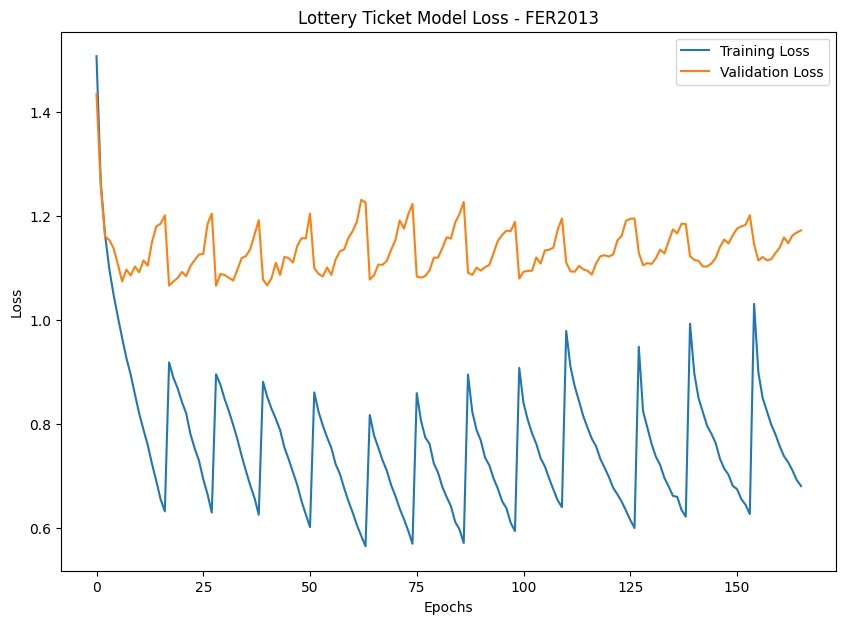

In [11]:
plot_losses(train_loss, val_loss, f'Lottery Ticket Model Loss - {data.upper()}')

In [13]:
min(train_loss)

0.564606127573207

In [14]:
min(val_loss)

1.0651798422226277